# Download Data

In [1]:
!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EfREjZqiZTlPqhqUPICBbPABdlgPumlaUVxPncm-_9aWIw?download=1 -O "Project 1 - data.zip"
!unzip -q "Project 1 - data.zip"

# Import Libraries

In [2]:
!pip -q install keras-layer-normalization

In [3]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization,\
    Activation, Input, Add, Concatenate, Embedding, Conv1D, MaxPool1D,\
    Flatten, LSTM, Bidirectional, MaxPooling1D, SimpleRNN, GRU
from keras_layer_normalization import LayerNormalization
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

# Data Loader

In [6]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

In [7]:
train_df = load_data('train', columns=['full'])
valid_df = load_data('valid', columns=['full'])
test_df = load_data('test', columns=['full'])

select [full] columns from the train split
Failed, then try to 
select all columns from the train split
select [full] columns from the valid split
Failed, then try to 
select all columns from the valid split
select [full] columns from the test split
Failed, then try to 
select all columns from the test split


# Feature Extractor

In [8]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """

    return [ps.stem(token).lower() for token in tokens]

In [9]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

# RNN Builder

In [10]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_rnn_layers: the number of layers of the RNN, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param rnn_type: the type of RNN, type: str
    :param bidirectional: whether to use bidirectional rnn, type: bool
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a RNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # recurrent layers document: https://keras.io/layers/recurrent
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=False)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

# Create Input Features

In [12]:
min_freq = 3

# load data
train_texts, train_labels = train_df["text"], train_df["stars"]
valid_texts, valid_labels = valid_df["text"], valid_df["stars"]

# extract features
train_tokens = [tokenize(text) for text in train_texts]
valid_tokens = [tokenize(text) for text in valid_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
valid_stemmed = [stem(tokens) for tokens in valid_tokens]

train_feats = train_stemmed
valid_feats = valid_stemmed

# build a mapping from features to indices
feats_dict = get_feats_dict(chain.from_iterable(train_feats), min_freq=min_freq)

Size of features: 9357


In [13]:
max_len = 100

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(valid_labels-1, num_classes=num_classes)

RNN

In [17]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="rnn", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

print(model.summary())

np.random.seed(0)
tf.random.set_seed(0)
rnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=1,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 100)          935700    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0   

LSTM

In [19]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
lstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 5ms/step - loss: 1.4022 - accuracy: 0.5060
training loss: 0.6698594689369202 training accuracy 0.8011000156402588
valid loss: 1.402228832244873 valid accuracy 0.5059999823570251


GRU

In [18]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="gru", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
gru_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 5ms/step - loss: 1.8846 - accuracy: 0.4885
training loss: 0.5284973382949829 training accuracy 0.8453999757766724
valid loss: 1.8845884799957275 valid accuracy 0.4884999990463257


RNN vs LSTM vs GRU

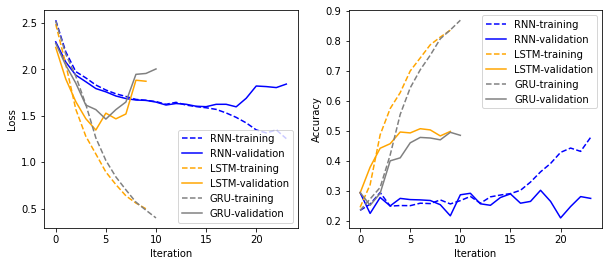

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(rnn_history.history["loss"], label="RNN-training", color="blue", linestyle="dashed")
plt.plot(rnn_history.history["val_loss"], label="RNN-validation", color="blue")
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="orange")
plt.plot(gru_history.history["loss"], label="GRU-training", color="gray", linestyle="dashed")
plt.plot(gru_history.history["val_loss"], label="GRU-validation", color="gray")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(rnn_history.history["accuracy"], label="RNN-training", color="blue", linestyle="dashed")
plt.plot(rnn_history.history["val_accuracy"], label="RNN-validation", color="blue")
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="orange")
plt.plot(gru_history.history["accuracy"], label="GRU-training", color="gray", linestyle="dashed")
plt.plot(gru_history.history["val_accuracy"], label="GRU-validation", color="gray")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Bidirectional LSTM

In [21]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 7ms/step - loss: 1.3064 - accuracy: 0.5345
training loss: 0.9227628707885742 training accuracy 0.7649999856948853
valid loss: 1.306418538093567 valid accuracy 0.534500002861023


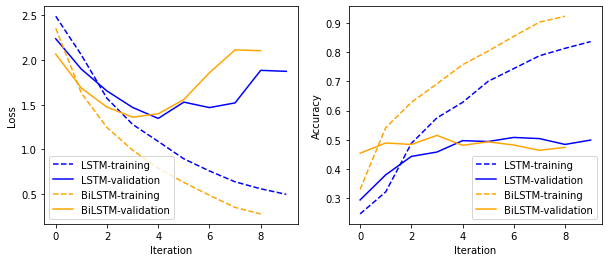

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.plot(bilstm_history.history["loss"], label="BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.plot(bilstm_history.history["accuracy"], label="BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Add word2vec embeddings and tune hyperparameters